🚀 Training Fold 1...
[0]	validation_0-rmse:1.09602
[100]	validation_0-rmse:1.05936
[200]	validation_0-rmse:1.04985
[300]	validation_0-rmse:1.04745
[400]	validation_0-rmse:1.04674
[500]	validation_0-rmse:1.04652
[600]	validation_0-rmse:1.04640
[700]	validation_0-rmse:1.04635
[800]	validation_0-rmse:1.04631
[900]	validation_0-rmse:1.04630
[1000]	validation_0-rmse:1.04628
[1100]	validation_0-rmse:1.04628
[1116]	validation_0-rmse:1.04627
✔ Fold 1 RMSLE: 1.04627
🚀 Training Fold 2...
[0]	validation_0-rmse:1.09482
[100]	validation_0-rmse:1.05816
[200]	validation_0-rmse:1.04877
[300]	validation_0-rmse:1.04647
[400]	validation_0-rmse:1.04584
[500]	validation_0-rmse:1.04566
[600]	validation_0-rmse:1.04561
[700]	validation_0-rmse:1.04558
[771]	validation_0-rmse:1.04558
✔ Fold 2 RMSLE: 1.04557
🚀 Training Fold 3...
[0]	validation_0-rmse:1.09471
[100]	validation_0-rmse:1.05882
[200]	validation_0-rmse:1.04953
[300]	validation_0-rmse:1.04726
[400]	validation_0-rmse:1.04661
[500]	validation_0-rmse:1.04

C:\Users\tungv\AppData\Local\Temp\ipykernel_37484\3699776918.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


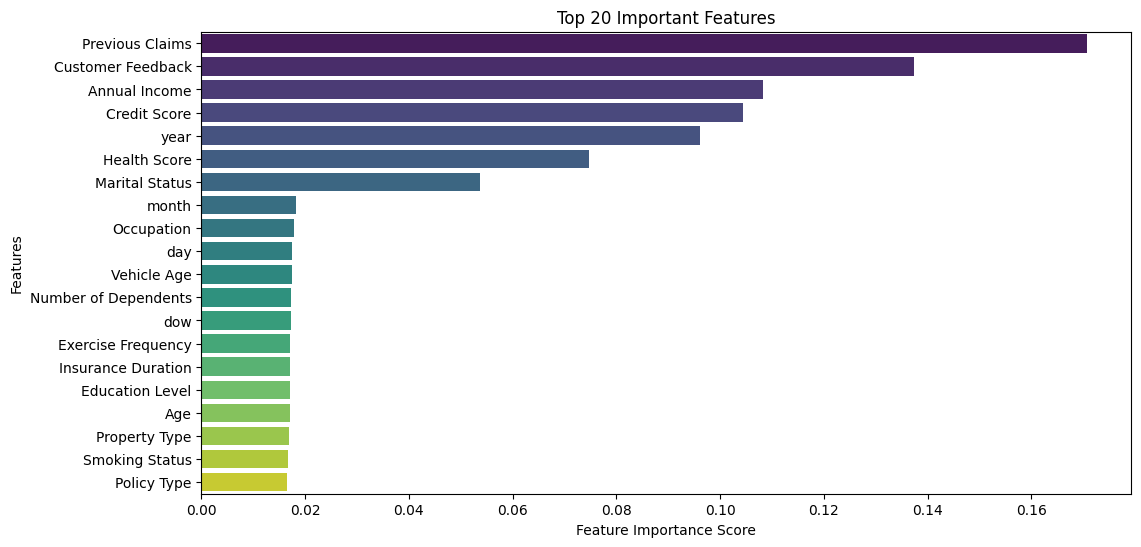

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

# 📌 Load Dataset
file_path = "train.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# 📌 Define Target Variable (Log Transformation to Reduce Skewness)
df["Premium Amount"] = np.log1p(df["Premium Amount"])  # log(1 + x) transformation

# 📌 Convert Date Features
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"])
df["year"] = df["Policy Start Date"].dt.year.astype("float32")
df["month"] = df["Policy Start Date"].dt.month.astype("float32")
df["day"] = df["Policy Start Date"].dt.day.astype("float32")
df["dow"] = df["Policy Start Date"].dt.dayofweek.astype("float32")
df.drop(columns=["Policy Start Date", "id"], inplace=True, errors="ignore")  # Remove ID and date column

# 📌 Identify Categorical and Numerical Features
cat_features = df.select_dtypes(include=["object"]).columns.tolist()
num_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_features.remove("Premium Amount")  # Exclude target variable

# 📌 Convert Categorical Features to "category" dtype for XGBoost
for col in cat_features:
    df[col] = df[col].astype("category")

# 📌 Define Features and Target
X = df.drop(columns=["Premium Amount"])
y = df["Premium Amount"]

# 📌 Cross-Validation Setup (5-Fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))  # Out-of-Fold Predictions
feature_importance_df = pd.DataFrame(index=X.columns)
rmsle_per_fold = []  # Store RMSLE per fold

# 📌 Train XGBoost with Cross-Validation
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"🚀 Training Fold {fold + 1}...")

    # Split Data
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # Train XGBoost Model with Native Categorical Handling
    model = XGBRegressor(
        enable_categorical=True,
        tree_method="hist",  # Optimized for speed
        max_depth=8,
        learning_rate=0.01,
        n_estimators=2000,
        colsample_bytree=0.9,
        subsample=0.9,
        early_stopping_rounds=50,
        eval_metric="rmse",
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    # Out-of-Fold Predictions
    fold_preds = model.predict(X_valid)
    oof_preds[valid_idx] = fold_preds

    # ✅ Calculate RMSLE for This Fold
    fold_rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(fold_preds)))
    rmsle_per_fold.append(fold_rmsle)
    print(f"✔ Fold {fold + 1} RMSLE: {fold_rmsle:.5f}")

    # ✅ Store Feature Importance
    feature_importance_df[f"Fold_{fold + 1}"] = model.feature_importances_

# 📌 Compute and Print Overall RMSLE
overall_rmsle = np.mean(rmsle_per_fold)
print("\n📊 Cross-Validation RMSLE Scores per Fold:")
for i, score in enumerate(rmsle_per_fold):
    print(f"✔ Fold {i + 1} RMSLE: {score:.5f}")
print(f"\n🚀 Overall Cross-Validation RMSLE: {overall_rmsle:.5f}")

# 📌 Compute Final RMSLE Using All Out-of-Fold Predictions
final_rmsle = np.sqrt(mean_squared_log_error(np.expm1(y), np.expm1(oof_preds)))
print(f"\n✅ Final Model RMSLE: {final_rmsle:.5f}")

# 📌 Compute Average Feature Importance
feature_importance_df["Average"] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values(by="Average", ascending=False)

# 📌 Plot Top 20 Important Features
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance_df["Average"][:20], 
    y=feature_importance_df.index[:20], 
    palette="viridis"
)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 20 Important Features")
plt.show()
